# Binary image classification with PCA and Random Forest algorithms

Nel seguente notebook ho voluto implementare due algoritmi di machine learning per la classificazione di immagini. 

La task del modello riguarda la classificazione binaria di immagini di chihuahua e muffin.

<div style="text-align: center;">
    <img src="nb_images/muffin-meme2.jpg" alt="Chihuahua vs Muffin" width="300"/>
</div>


In particolare, visto l'alto numero di features per ogni dato (immagini 120x120x3), ho combinato due tecniche:
 - **Principal Component Analysis** (PCA)
 - **Random Forest**
   

## Dataset

Il dataset utilizzato è stato scaricato da Kaggle (qui il [link](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)) e consiste in 6000 immagini tra chihuahua e muffin già divise in 80% train e 20% test.

*disclaimer*: L'autore del dataset ha ottenuto le immagini mediante scraping di google images per cui scaricando risultati di ricerca per un dato prompt al motore di ricerca. Questo ha portato ad un dataset non pulitissimo che contiene alcune immagini non inerenti alla categorie sopra citate

Iniziamo quindi a caricare il dataset, prima però importiamo le librerie necessarie 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

import ast

/Users/lorenzoesposito/miniconda3/envs/myenv/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Carichiamo le immagini in codifica rgb e le normalizziamo per 255, in quanto la codifica rgb prevede un valore del pixel rappresentato da 8 bit e gli algoritmi che utilizzeremo lavorano meglio su scale normalizzate

In [4]:
# path to the data, verify that the path is correct in your computer
train_data_path = 'muffin/train'
val_data_path = 'muffin/test'

# load the images
data_loader = ImageDataGenerator(rescale=1./255) # rescale the images
train_data = data_loader.flow_from_directory(train_data_path, target_size=(120, 120), batch_size=4733, class_mode='binary', seed=1)
val_data = data_loader.flow_from_directory(val_data_path, target_size=(120, 120), batch_size=1184, class_mode='binary', seed = 1)

# load the labels
(train_images, train_labels) = next(train_data)
(val_images, val_labels) = next(val_data)

print('Train data shape:', train_images.shape)
print('Validation data shape:', val_images.shape)

Found 4732 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
Train data shape: (4732, 120, 120, 3)
Validation data shape: (1184, 120, 120, 3)


Vediamo alcune immagini del dataset di train e come sono distribuite fra le due categorie

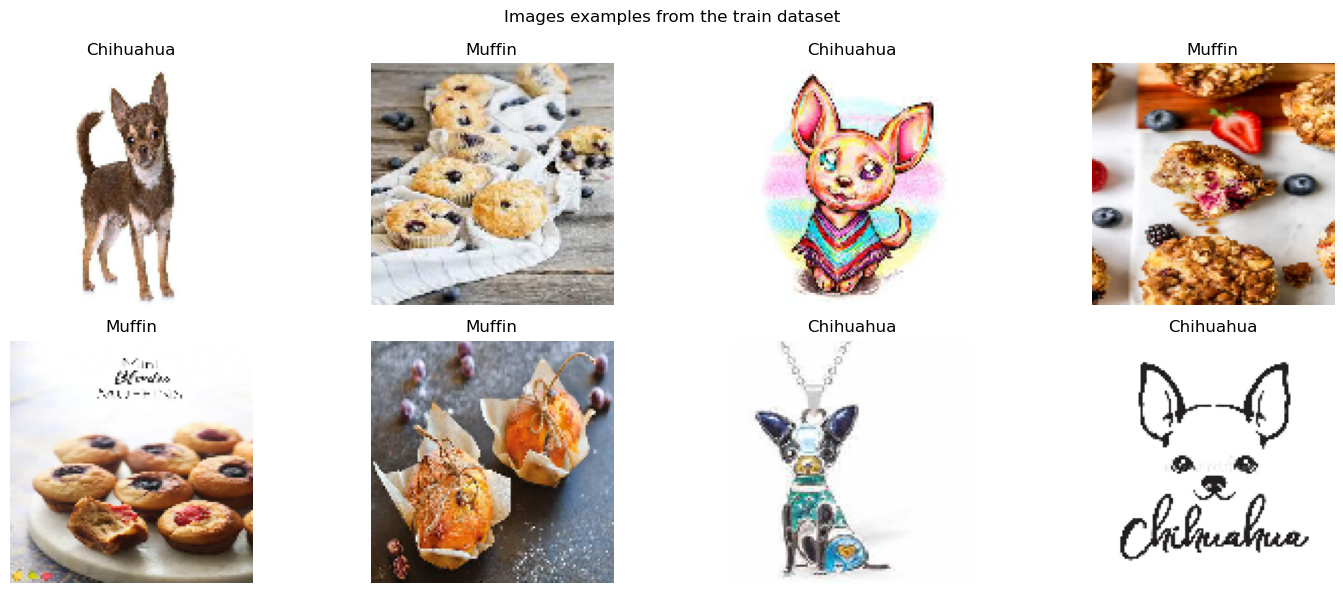

In [5]:
# Display some example images from the train dataset with labels
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()

for img, label, ax in zip(train_images[:10], train_labels[:10], axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Chihuahua' if label == 0 else 'Muffin')

plt.suptitle('Images examples from the train dataset')
plt.tight_layout()
plt.show()

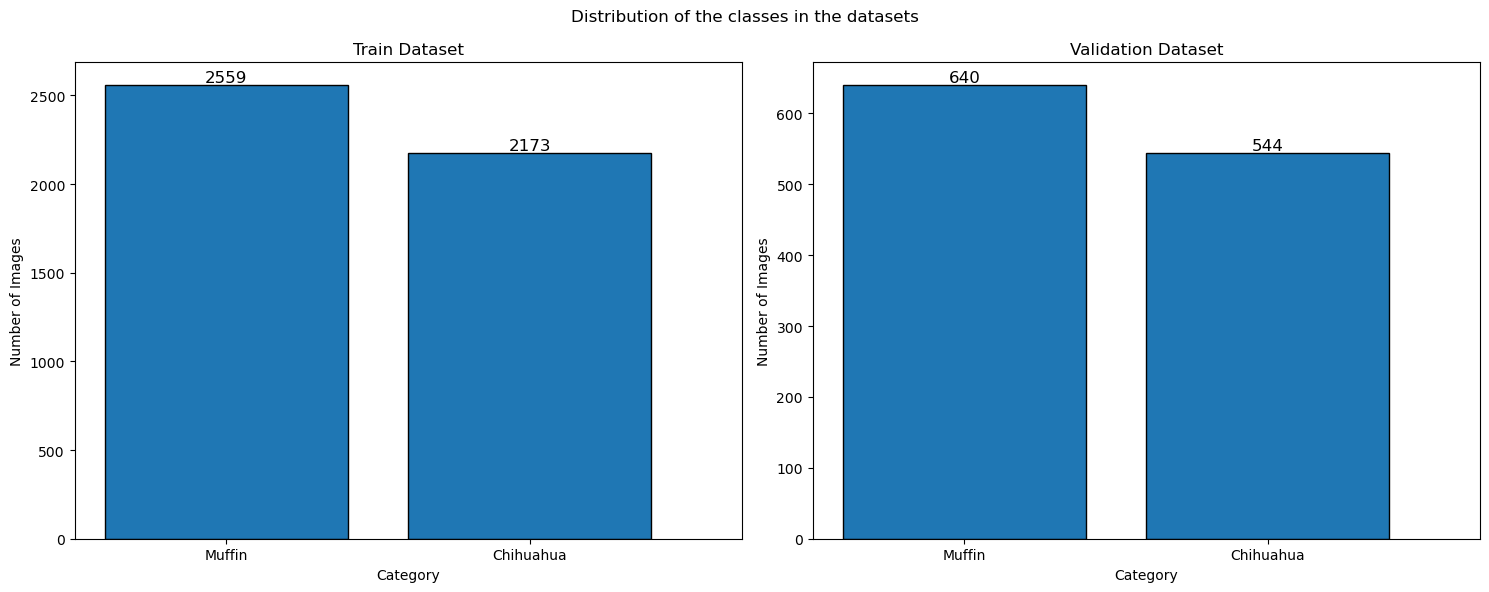

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Train dataset histogram
n_train, bins_train, patches_train = axes[0].hist(train_labels, bins=2, edgecolor='black', width=0.4)
axes[0].set_title('Train Dataset')
axes[0].set_xticks([0.2, 0.7])
axes[0].set_xticklabels(['Muffin', 'Chihuahua'])
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Images')

# Annotate the heights of the bins
for i in range(len(n_train)):
    axes[0].annotate(str(int(n_train[i])), xy=(bins_train[i] + 0.2, n_train[i]), ha='center', va='bottom', fontsize=12)

# Validation dataset histogram
n_val, bins_val, patches_val = axes[1].hist(val_labels, bins=2, edgecolor='black', width=0.4)
axes[1].set_title('Validation Dataset')
axes[1].set_xticks([0.2, 0.7])
axes[1].set_xticklabels(['Muffin', 'Chihuahua'])
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number of Images')

# Annotate the heights
for i in range(len(n_val)):
    axes[1].annotate(str(int(n_val[i])), xy=(bins_val[i] + 0.2, n_val[i]), ha='center', va='bottom', fontsize=12)

plt.suptitle('Distribution of the classes in the datasets')
plt.tight_layout()
plt.show()

Le due classi non hanno esattamento lo stesso numero di immagini ma la differenza non è sostanziale 

## Riduzione della dimensionalità con PCA

Gli algoritmi di machine learning prevedono che i dati siano rappresentati nella **Matrice di Design** $X$, dove le sue colonne $$\vec{x}_j \quad \text{con } j = 1,...,p$$
rappresentano la j-esima feature per ogni osservazione (nel nostro caso il valore di un pixel fissato) e le sue righe  $$\underline{x}_i \quad \text{con } i = 1,...,N$$

rappresentano la i-esima osservazione del dataset (nel nostro caso un'immagine).

E' quindi necessario "appiattire" le nostre immagini trasformandole da tensori $120 \times 120 \times 3$ ad array monodimensionali di lunghezza $43200$.

Questo appiattimento potrebbe portare ad una minor sensibilità alle correlazioni spaziali 2D, fondamentali per la classificazione di immagini, ma non necessariamente rende inagibile il task con algoritmi che lavorano con dati 1D come il nostro

In [7]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2]*train_images.shape[3])
test_images = val_images.reshape(val_images.shape[0], val_images.shape[1]*val_images.shape[2]*val_images.shape[3])

print(f'dimension of train_images after reshaping: {train_images.shape}')
print(f'dimension of test_images after reshaping: {test_images.shape}')


dimension of train_images after reshaping: (4732, 43200)
dimension of test_images after reshaping: (1184, 43200)


### Analisi Varianza con PCA

L'Analisi delle Componenti Principali è una tecnica per ridurre la dimensionalità dei dati. 

Utilizzando solo le componenti dei dati più "significative" individuate dalla PCA è possibile ottenere ottimi risultati aumentando l'efficienza computazionale degli algoritmi di Machine Learning

Consideriamo un Dataset di $N$ osservazioni, ciascuna caratterizzata da $p$ features, organizziamo i dati nella matrice di design

$$X \in \mathbb{R}^{N\times p}$$ 

centrando i dati nel centro di massa ($\underline{X} \to \underline{X} - <\underline{X}>$).

La matrice di covarianza a partire dai dati campionati si stima come 

$$C[X] = \frac{1}{N-1} \sum_{i=1}^N (\underline{x}_i-<\underline{x}_i>)^T (\underline{x}_i-<\underline{x}_i>) = \frac{1}{N} X^TX \in \mathbb{R}^{p\times p}$$

$$
C[X] = \begin{pmatrix}
\text{Var}(x_1) & \text{Cov}(x_1, x_2) & \cdots & \text{Cov}(x_1, x_p) \\
\text{Cov}(x_2, x_1) & \text{Var}(x_2) & \cdots & \text{Cov}(x_2, x_p) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(x_p, x_1) & \text{Cov}(x_p, x_2) & \cdots & \text{Var}(x_p)
\end{pmatrix}
$$

questa matrice è simmetrica e definita positiva, è possibile quindi diagonalizzarla ottenendo autovalori positivi

$$C[X] = V\Sigma^2V^T \quad \text{con } V = (\vec{v}_1, ... ,\vec{v}_p) \quad \text{e } \Sigma^2 = diag(\sigma_1,...,\sigma_p)

Gli autovalori $\sigma_i$ rappresentano le varianze relative alle direzioni rappresentati dai vettori $\vec{v}_i$.

Il teorema PCA ci permette di approssimare un dataset utilizzando solo le direzioni a cui corrispondono gli autovalori più grandi.

Andiamo quindi a vedere per il nostro dataset quante componenti corrispondono per una certa percentuale di varianza utilizzando la libreria Scikit-learn

In [8]:
var_pca = PCA()
var_pca.fit(train_images)

PCA()

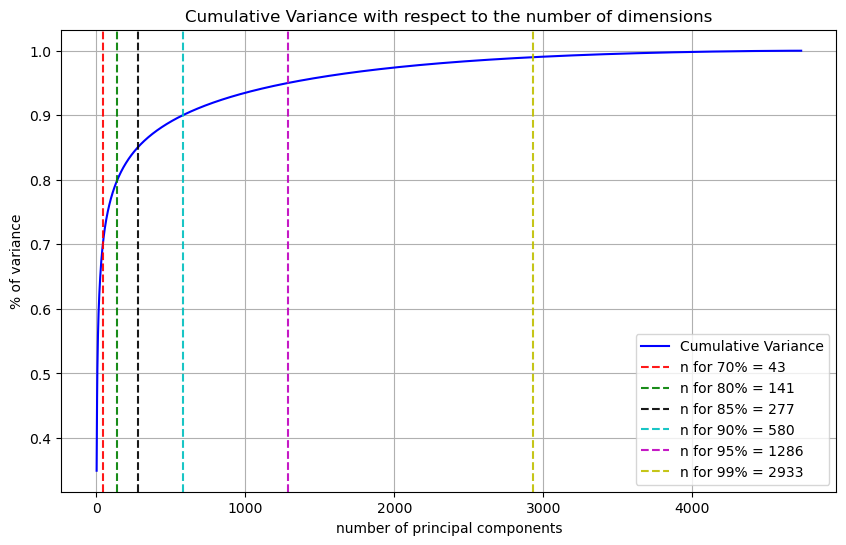

In [9]:
# evaluate cumulative variance
cumsum = np.cumsum(var_pca.explained_variance_ratio_)

var_70 = np.argmax(cumsum >= 0.70) + 1
var_80 = np.argmax(cumsum >= 0.80) + 1
var_85 = np.argmax(cumsum >= 0.85) + 1
var_90 = np.argmax(cumsum >= 0.90) + 1
var_95 = np.argmax(cumsum >= 0.95) + 1
var_99 = np.argmax(cumsum >= 0.99) + 1

data_var = [
    ["70%", var_70],
    ["80%", var_80],
    ["85%", var_85],
    ["90%", var_90],
    ["95%", var_95],
    ["99%", var_99],
]

# plot the cumulative variance  
colors = ['r', 'g', 'k', 'c', 'm', 'y']
plt.figure(figsize=(10, 6))
plt.title('Cumulative Variance with respect to the number of dimensions')
plt.plot(range(1, len(cumsum) + 1),cumsum, color = 'b', label='Cumulative Variance')
plt.axvline(x=var_70, ls='--', alpha = 0.9, color=colors[0], label='n for 70% = ' + str(var_70))
plt.axvline(x=var_80, ls='--', alpha = 0.9, color=colors[1], label='n for 80% = ' + str(var_80))
plt.axvline(x=var_85, ls='--', alpha = 0.9, color=colors[2], label='n for 85% = ' + str(var_85))
plt.axvline(x=var_90, ls='--', alpha = 0.9, color=colors[3], label='n for 90% = ' + str(var_90))
plt.axvline(x=var_95, ls='--', alpha = 0.9, color=colors[4], label='n for 95% = ' + str(var_95))
plt.axvline(x=var_99, ls='--', alpha = 0.9, color=colors[5], label='n for 99% = ' + str(var_99))
plt.ylabel('% of variance')
plt.xlabel('number of principal components')
plt.legend(loc=4)
plt.grid()
plt.show()

Dal plot possiamo notare una crescita importante all'inizio per poi diminuire già a partire da circa 150/200 componenti. Il numero di componenti analizzate è limitato dal numero di osservazioni.

Per avere un'idea di cosa significa concretamente ridurre il numero di componenti principali di un'immagine mostriamo la stessa immagine ridotta per diverso numero di componenti

<div style="text-align: center;">
    <img src="nb_images/diff_pca.png" alt="Chihuahua vs Muffin" width="1200"/>
</div>

Allego il codice commentato per eseguire questo processo su tutte le immagini

In [10]:
# This is the code to plot the images with different number of components, it takes quite a bit of time to run so I commented it out 

'''
pca_80 = PCA(n_components=0.80) 
pca_85 = PCA(n_components=0.85)
pca_90 = PCA(n_components=0.90)
pca_95 = PCA(n_components=0.95)

train_images_reduced_80 = pca_80.fit_transform(train_images)
train_images_reduced_85 = pca_85.fit_transform(train_images)
train_images_reduced_90 = pca_90.fit_transform(train_images)
train_images_reduced_95 = pca_95.fit_transform(train_images)

reconstructed_images_80 = pca_80.inverse_transform(train_images_reduced_80)
reconstructed_images_85 = pca_85.inverse_transform(train_images_reduced_85)
reconstructed_images_90 = pca_90.inverse_transform(train_images_reduced_90)
reconstructed_images_95 = pca_95.inverse_transform(train_images_reduced_95)
'''

'\npca_80 = PCA(n_components=0.80) \npca_85 = PCA(n_components=0.85)\npca_90 = PCA(n_components=0.90)\npca_95 = PCA(n_components=0.95)\n\ntrain_images_reduced_80 = pca_80.fit_transform(train_images)\ntrain_images_reduced_85 = pca_85.fit_transform(train_images)\ntrain_images_reduced_90 = pca_90.fit_transform(train_images)\ntrain_images_reduced_95 = pca_95.fit_transform(train_images)\n\nreconstructed_images_80 = pca_80.inverse_transform(train_images_reduced_80)\nreconstructed_images_85 = pca_85.inverse_transform(train_images_reduced_85)\nreconstructed_images_90 = pca_90.inverse_transform(train_images_reduced_90)\nreconstructed_images_95 = pca_95.inverse_transform(train_images_reduced_95)\n'

In [11]:
'''
index = np.random.randint(0, len(train_images))

original_image = train_images[index].reshape(120, 120, 3)
reconstructed_image_80 = reconstructed_images_80[index].reshape(120, 120, 3)
reconstructed_image_85 = reconstructed_images_85[index].reshape(120, 120, 3)
reconstructed_image_90 = reconstructed_images_90[index].reshape(120, 120, 3)
reconstructed_image_95 = reconstructed_images_95[index].reshape(120, 120, 3)


plt.figure(figsize=(20, 5))

# Image reduced to 80% of the variance
plt.subplot(1, 5, 1)
plt.imshow(reconstructed_image_80, cmap='gray')
plt.title(f'n_components: {pca_80.components_.shape[0]}')
plt.axis('off')

# Image reduced to 85% of the variance
plt.subplot(1, 5, 2)
plt.imshow(reconstructed_image_85, cmap='gray')
plt.title(f'n_components: {pca_85.components_.shape[0]}')
plt.axis('off')

# Image reduced to 90% of the variance
plt.subplot(1, 5, 3)
plt.imshow(reconstructed_image_90, cmap='gray')
plt.title(f'n_components: {pca_90.components_.shape[0]}')
plt.axis('off')

# Image reduced to 95% of the variance
plt.subplot(1, 5, 4)
plt.imshow(reconstructed_image_95, cmap='gray')
plt.title(f'n_components: {pca_95.components_.shape[0]}')
plt.axis('off')

# original image
plt.subplot(1, 5, 5)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()
'''

"\nindex = np.random.randint(0, len(train_images))\n\noriginal_image = train_images[index].reshape(120, 120, 3)\nreconstructed_image_80 = reconstructed_images_80[index].reshape(120, 120, 3)\nreconstructed_image_85 = reconstructed_images_85[index].reshape(120, 120, 3)\nreconstructed_image_90 = reconstructed_images_90[index].reshape(120, 120, 3)\nreconstructed_image_95 = reconstructed_images_95[index].reshape(120, 120, 3)\n\n\nplt.figure(figsize=(20, 5))\n\n# Image reduced to 80% of the variance\nplt.subplot(1, 5, 1)\nplt.imshow(reconstructed_image_80, cmap='gray')\nplt.title(f'n_components: {pca_80.components_.shape[0]}')\nplt.axis('off')\n\n# Image reduced to 85% of the variance\nplt.subplot(1, 5, 2)\nplt.imshow(reconstructed_image_85, cmap='gray')\nplt.title(f'n_components: {pca_85.components_.shape[0]}')\nplt.axis('off')\n\n# Image reduced to 90% of the variance\nplt.subplot(1, 5, 3)\nplt.imshow(reconstructed_image_90, cmap='gray')\nplt.title(f'n_components: {pca_90.components_.shape

## Pipeline PCA + Random Forest

Il Random Forest è un algoritmo di ensemble learning che addestra diversi modelli predittivi e combina i loro risultati; un esempio di questa combinazione è la votazione a maggioranza, che determina la previsione finale per un dato di input.

Le predizioni così costruite sono molto spesso migliori rispetto a quelle ottenute con il miglior modello preso singolarmente.

Nel random Forest tutti i predittori sono **Decision Trees**, modelli di machine learning che spiegheremo in seguito. 

In questo notebook ho voluto inizialmente valutare quale fosse il miglior numero di componenti principali da utilizzare per ottenere un modello di classificazione sia accurato sia computazionalmente efficiente. 

Per questo attraverso la funzione `GridSearchCV` di Scikit-Learn sono andato a valutare per diversi valori di componenti principali (corrispondenti a percentuali di varianze spiegate) e per diverso numero di stimatori (numero di alberi della foresta) quale fosse la miglior scelta di iperparametri

In [12]:
pca_components = [ np.argmax(cumsum >= i) + 1 for i in np.arange(0.7, 0.95, 0.05)]
n_trees = [10, 50, 100, 500, 1000]

pcrf = make_pipeline(PCA(random_state=36), RandomForestClassifier(random_state=63))

param_distrib = {
"pca__n_components": pca_components,
"randomforestclassifier__n_estimators": n_trees
}

# Grid search takes a lot of time to run so i commented it out, there is the csv file with the results of the grid search in the repository

#search = GridSearchCV(pcrf, param_distrib, cv=10, verbose=1, n_jobs=-1)
#search.fit(train_images, train_labels)

#print(search.best_params_)

#d_best = search.best_params_['pca__n_components']
#estim = search.best_params_['randomforestclassifier__n_estimators']

# save the best parameters

#results = pd.DataFrame(search.cv_results_)
#display(results[['params', 'mean_test_score', 'std_test_score']])
#display(results)
#results.to_csv('csv_results/PCA_search.csv')

Non avendo un grande dataset di allenamento, ho sfruttato `GridSearchCV` che permette di eseguire una Cross-Validation per monitorare l'errore di generalizzazione del modello, la funzione `make_pipeline` permette di concatenare PCA e Random Forest prima di essere utilizzati nella Grid Search.

Inoltre questo permette di eseguire la divisione del dataset dalla k-fold CV **prima** della selezione dei predittori con PCA.

Siccome la ricerca dei parametri è un processo lungo ho commentato il codice che effettua la gridsearch e ne salva i risultati, questi sono disponibili nel file *PCA_search.csv*

In [13]:
results = pd.read_csv('csv_results/grid_search_PCA.csv')

# show complete dataframe
#display(results)

results['params'] = results['params'].apply(ast.literal_eval) 

mean_score = results['mean_test_score']
std_score = results['std_test_score']

pca_values = results['params'].apply(lambda x: x['pca__n_components'])
n_estimators = results['params'].apply(lambda x: x['randomforestclassifier__n_estimators'])

print(f'best mean score: {mean_score.max()}')
print(f'standard deviation of the best mean score: {std_score[mean_score.idxmax()]}')
print(f'achieved with pca components: {pca_values[mean_score.idxmax()]}, and n_estimators: {n_estimators[mean_score.idxmax()]}')

best mean score: 0.8087479148268081
standard deviation of the best mean score: 0.0208511035098122
achieved with pca components: 141, and n_estimators: 1000


Mostriamo i plot della accuracy media per diversi valori di *n_components* e *n_estimators*

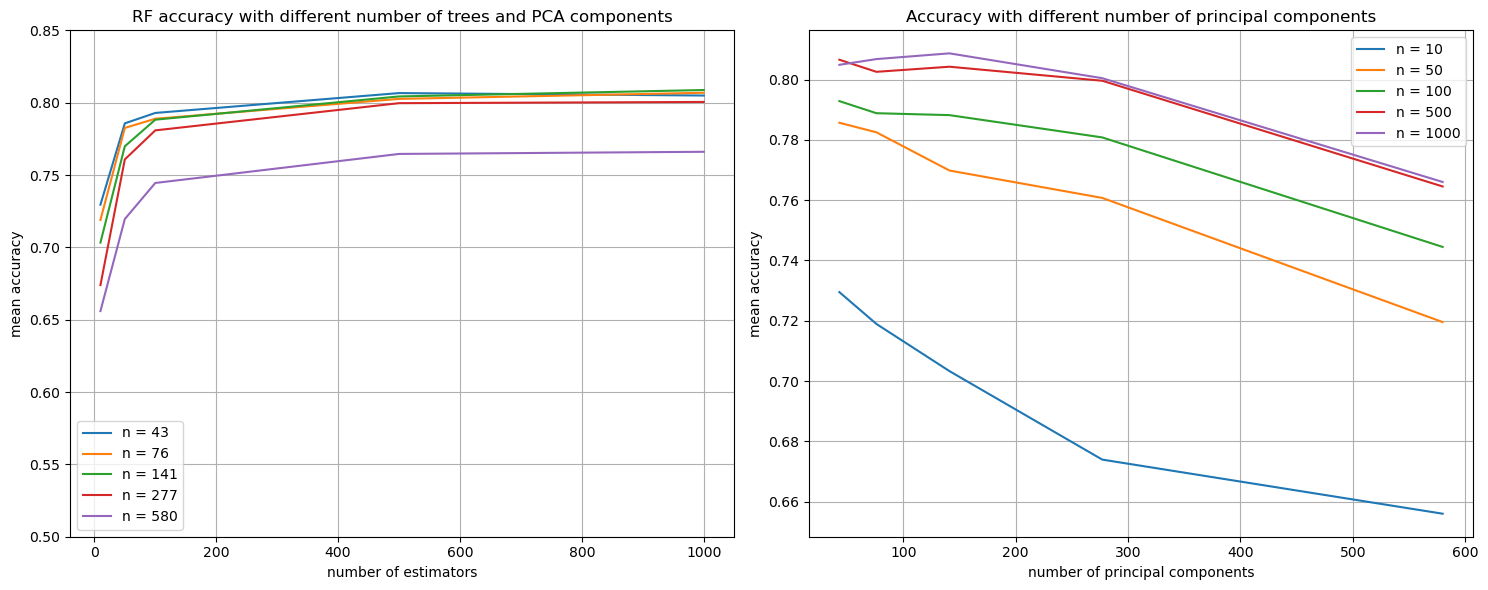

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i in range(5):
    a = 5*i
    axes[0].plot(n_estimators[a:a+5], mean_score[a:a+5], label='n = ' + str(pca_values[a]))
axes[0].set_xscale('linear')
axes[0].set_ylim([0.5, 0.85])
axes[0].set_title('RF accuracy with different number of trees and PCA components')
axes[0].set_xlabel('number of estimators')
axes[0].set_ylabel('mean accuracy')
axes[0].legend()
axes[0].grid()

for i in range(5):
    axes[1].plot(pca_values[i::5], mean_score[i::5], label='n = ' + str(n_estimators[i]))
axes[1].set_title('Accuracy with different number of principal components')
axes[1].set_xlabel('number of principal components')
axes[1].set_ylabel('mean accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

## Random Forest hyperparameters tuning 

Scelti i migliori valori della Grid Search siamo ora interessati nella scelta dei parametri ottimali del modello random forest, che abbiamo detto essere un algoritmo di ensemble learning con alberi decisionali.

### Random Forests

Gli alberi decisionali sono algoritmi di ML che sostanzialmente partizionano in modo ricorsivo il dominio delle feature. Dopo l'allenamento la predizione su un'osservazione è data in base a quale partizione (ramo) questa appartiene.

Allenando diversi alberi decisionali sullo stesso dataset (usando eventualmente anche diversi dati di training), e cercando la miglior caratteristica di split in un sottoinsieme random di caratteristiche, si forma una foresta casuale (Random Forest), ogni albero fa una predizione e la predizione finale è decisa (secondo un voting arbitrario, nel caso di classificazione a maggioranza) sulla base di tutte le previsioni della foresta. 

Sempre con `GridSearchCV` sono andato a valutare a fissato numero di alberi della foresta i seguenti iperparametri:

 - `max_depth`: indica la profondità massima degli alberi, a che livello la divisione ricorsiva si ferma

 - `bootstrap`: Indica se è stato utilizzato bootstrap, ovvero determina se gli alberi della foresta vengono addestrati utilizzando un campionamento casuale con sostituzione 

 - `criterion`: è la funzione che misura la qualità di split
 
 - `max_features`: controlla il numero massimo di caratteristiche che ogni albero considera a ogni split dei nodi. ad esempio 'log2' utilizza il logaritmo in base 2 del numero di caratteristiche.

In [15]:
pca_best = pca_values[mean_score.idxmax()]
n_estim_best = n_estimators[mean_score.idxmax()]

# PCA con dimensione pari a d_best
pca_best = PCA(n_components=pca_best)
X_train = pca_best.fit_transform(train_images)
X_test = pca_best.transform(test_images)

pcrf2 = make_pipeline(RandomForestClassifier(n_estimators=n_estim_best, random_state=12, n_jobs=-1))

param_distrib = {
    'randomforestclassifier__max_depth': [10, 20, 30, 40, 50, None],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}


# Grid search takes a bit of time to run so i commented it out, there is the csv file with the results of the grid search in the repository

#param_search2 = GridSearchCV(pcrf, param_distrib, cv=10, verbose=3, n_jobs=-1)
#param_search2.fit(X_train, train_labels)

#results2 = pd.DataFrame(param_search2.cv_results_)
#results2.to_csv('csv_results/rf_tuning.csv')

In [16]:
results2 = pd.read_csv('csv_results/rf_tuning.csv')

#display(results2)

results2['params'] = results2['params'].apply(ast.literal_eval)

mean_score2 = results2['mean_test_score']
std_score2 = results2['std_test_score']

print(f'best score: {mean_score2.max()}')
print(f'standard deviation of the best score: {std_score2[mean_score2.idxmax()]}')
print(f'achieved with parameters: {results2["params"][mean_score2.idxmax()]}')

best score: 0.8043099526320014
standard deviation of the best score: 0.0199366569061082
achieved with parameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'sqrt'}


Vediamo un plot dei risultati di ricerca di iperparametri

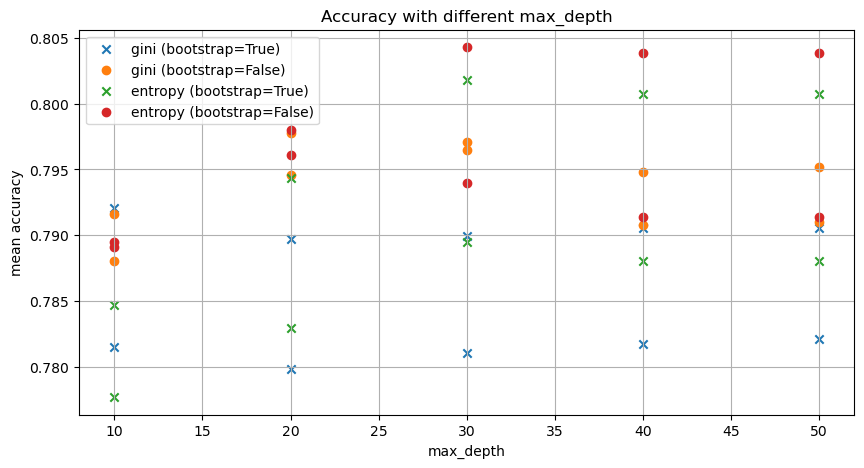

In [17]:
gini = results2[results2['param_randomforestclassifier__criterion'] == 'gini']
entropy = results2[results2['param_randomforestclassifier__criterion'] == 'entropy']

def plot_with_bootstrap(data, label):
    bootstrap_true = data[data['param_randomforestclassifier__bootstrap'] == True]
    bootstrap_false = data[data['param_randomforestclassifier__bootstrap'] == False]
    
    plt.scatter(bootstrap_true['param_randomforestclassifier__max_depth'], bootstrap_true['mean_test_score'], label=f'{label} (bootstrap=True)', marker='x')
    plt.scatter(bootstrap_false['param_randomforestclassifier__max_depth'], bootstrap_false['mean_test_score'], label=f'{label} (bootstrap=False)', marker='o')

plt.figure(figsize=(10, 5))
plot_with_bootstrap(gini, 'gini')
plot_with_bootstrap(entropy, 'entropy')

plt.title('Accuracy with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean accuracy')
plt.legend()
plt.grid()
plt.show()

Notiamo che il tuning è molto fine si parla di circa due punti percentuali in accuracy tra il migliore e il peggior modello

Costruiamo quindi il miglior modello e verifichiamo le perfomance sul dataset di test 

In [ ]:
# train the model with the best parameters
best_params = results2['params'][mean_score2.idxmax()]
pcrf2.set_params(**best_params)
pcrf2.fit(X_train, train_labels)

# evaluate the model
score = pcrf2.score(X_test, val_labels)
print(f'Accuracy: {score}')
print(f'variance accuracy: {np.var(mean_score2)}')

Accuracy: 0.8133445945945946
variance accuracy: 4.583589783943044e-05


Per mostrare l'efficacia dell'ensemble learning mostriamo la differenza in accuracy rispetto ad un solo albero decisionale con i migliori parametri trovati

In [19]:
# same parameters as the best model but with only 1 tree
from sklearn.tree import DecisionTreeClassifier

pcrf3 = DecisionTreeClassifier(max_depth=best_params['randomforestclassifier__max_depth'], criterion=best_params['randomforestclassifier__criterion'], random_state=12)
pcrf3.fit(X_train, train_labels)
score = pcrf3.score(X_test, val_labels)
print(f'Accuracy with 1 tree: {score}')

Accuracy with 1 tree: 0.6722972972972973


Si tratta di oltre il 10% di differenza

Mostriamo un plot di alcune predizioni con relative probabilità

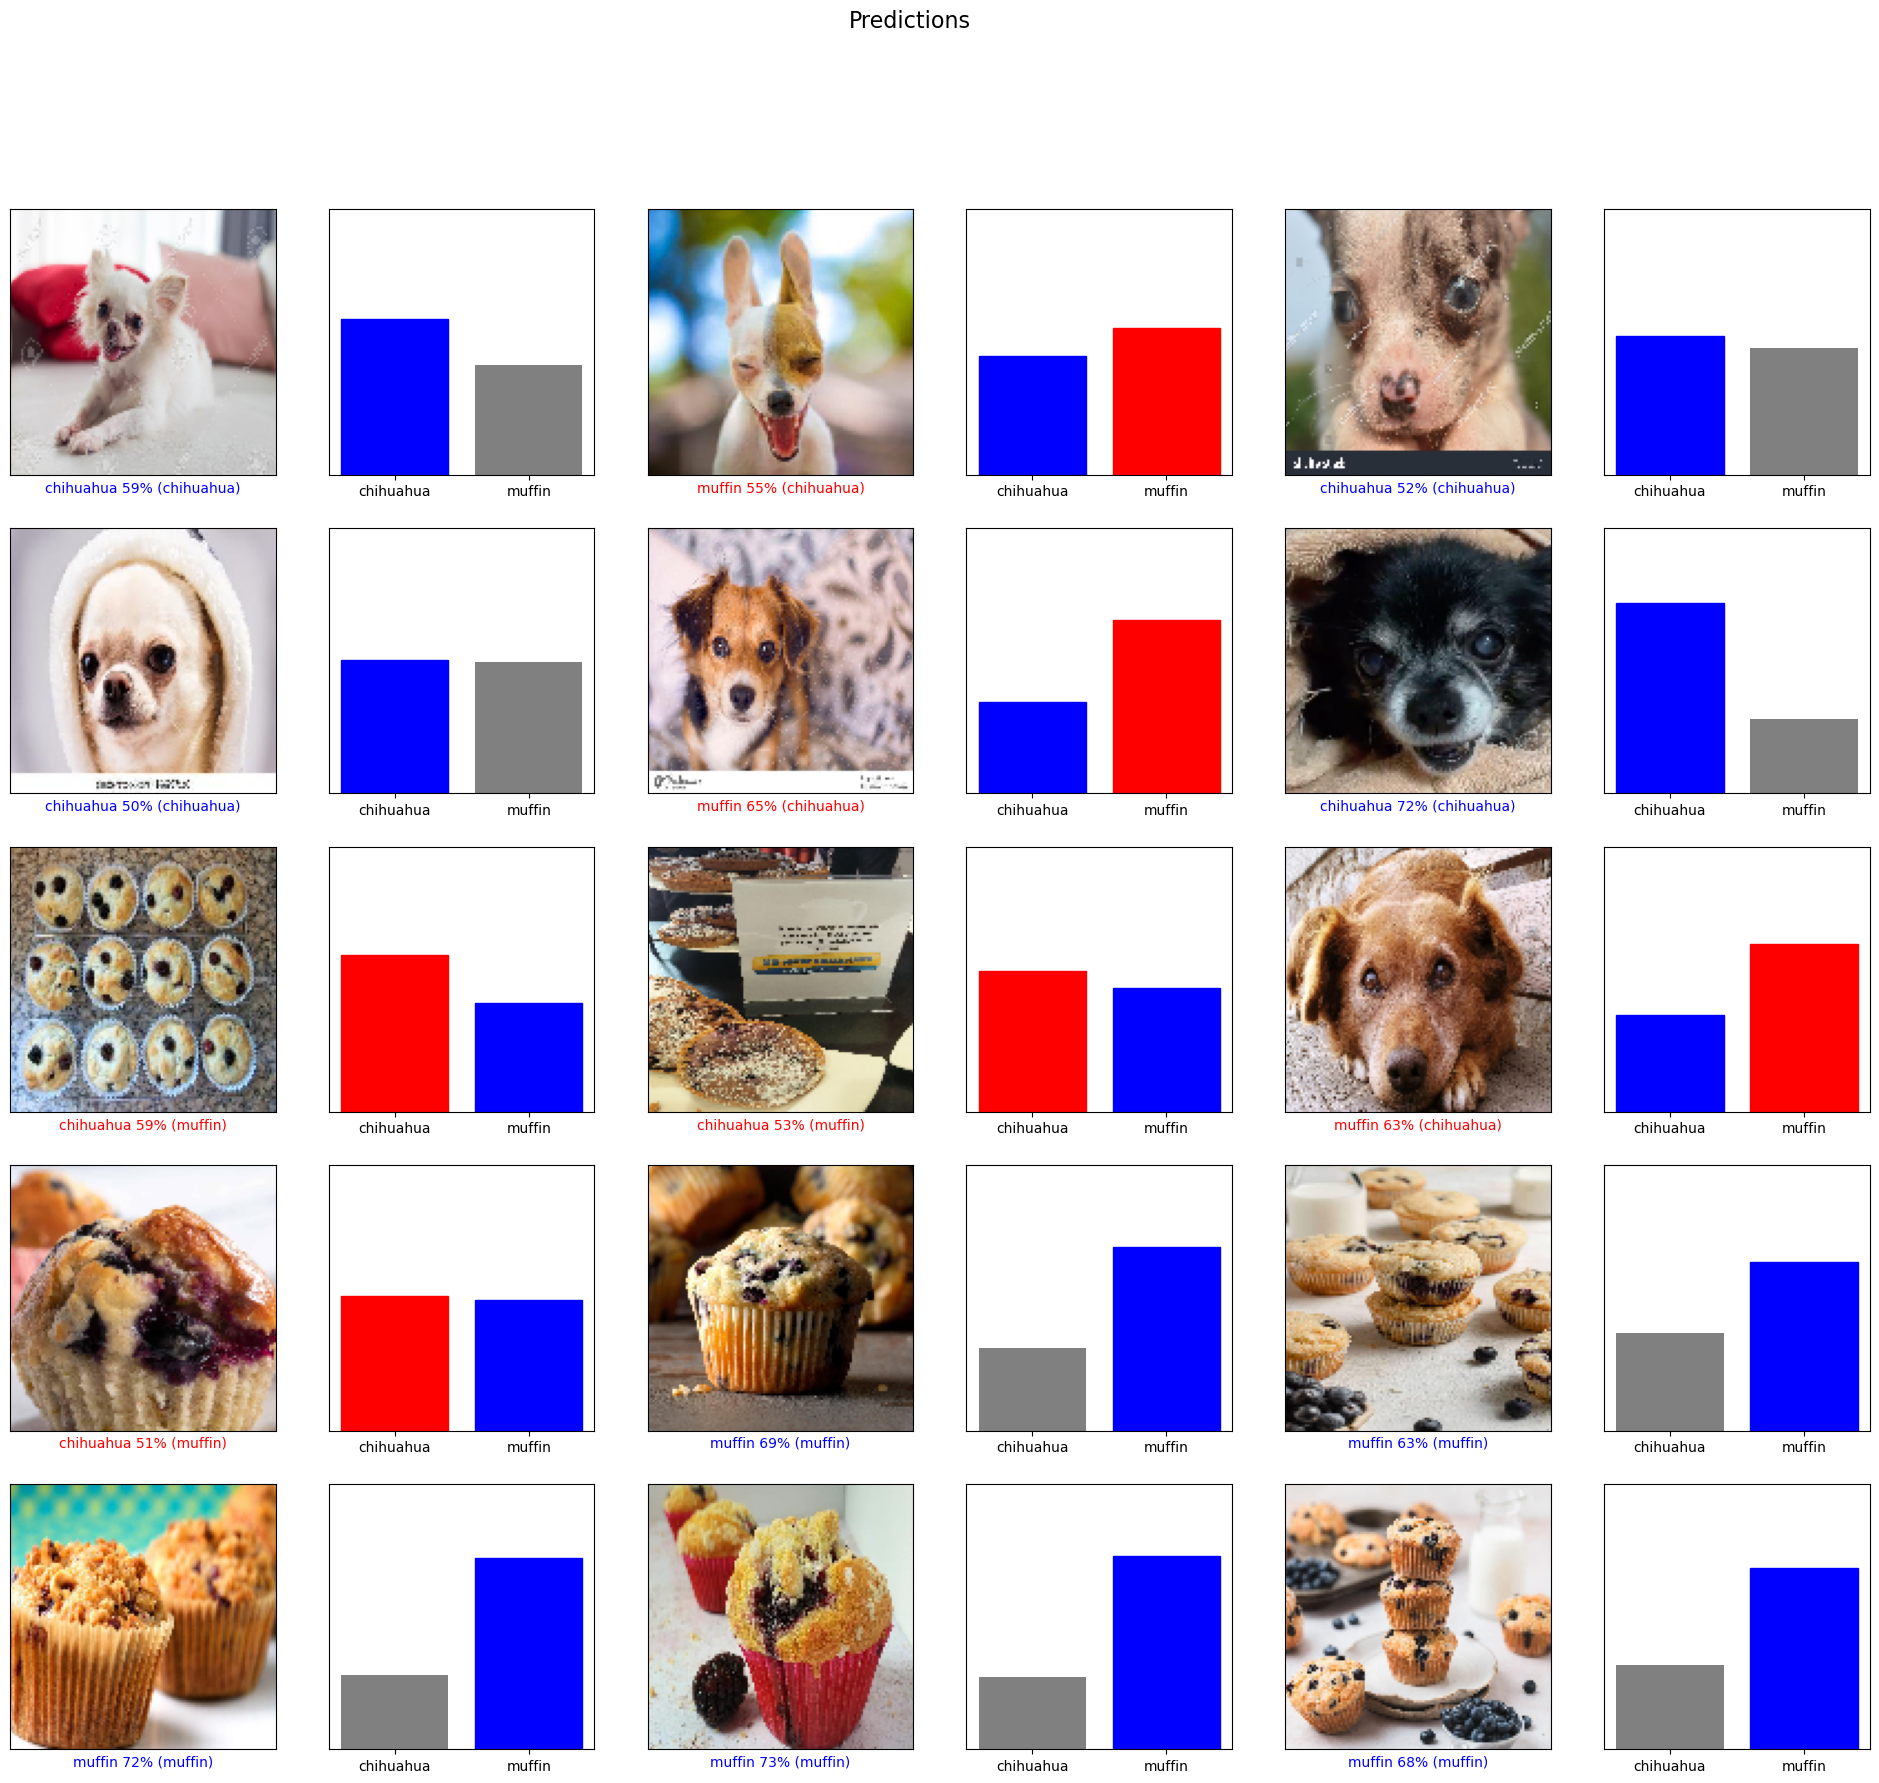

In [20]:
classes = ['chihuahua', 'muffin']

def plot_predictions(predictions, images, labels, title):
    rows = 5
    cols = 3
    plt.figure(figsize=(8*cols, 4*rows))
    indices = np.arange(len(predictions))
    np.random.shuffle(indices)
    selected_indices = indices[:rows * cols]

    for i, idx in enumerate(selected_indices):
        idx = int(idx)  # Converti l'indice in int
        plt.subplot(rows, 2*cols, 2 * i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.yticks([])
        plt.xticks([])
        predicted_label = int(np.argmax(predictions[idx]))  
        if predicted_label == int(labels[idx]): 
            color = 'blue'
        else:
            color = 'red'
        plt.xlabel(f"{classes[predicted_label]} {100*np.max(predictions[idx]):2.0f}% ({classes[int(labels[idx])]})", color=color)  

        plt.subplot(rows, 2*cols, 2 * i + 2)
        tp = plt.bar(range(len(classes)), predictions[idx], color='grey')
        tp[predicted_label].set_color('red')
        tp[int(labels[idx])].set_color('blue')  
        plt.yticks([])
        plt.xticks(range(len(classes)), classes)
        plt.ylim([0,1])

    plt.suptitle(title, fontsize=16)
    plt.show()

predictions = pcrf2.predict_proba(X_test)
plot_predictions(predictions, test_images.reshape(-1, 120, 120, 3), val_labels, 'Predictions')

Per visualizzare meglio le predizioni corrette e sbagliate creiamo la matrice di confusione, che mostra per ogni categoria quante predizioni corrispondono e quante sono sbagliate

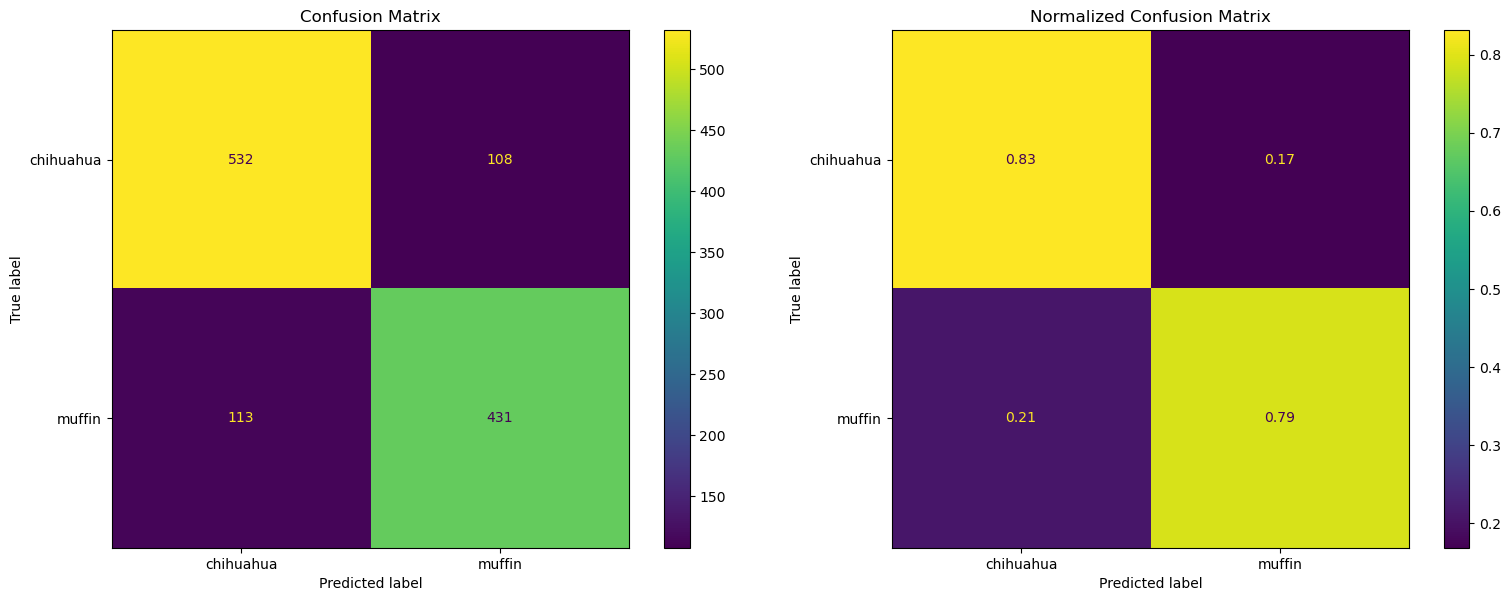

In [21]:
predictions = pcrf2.predict(X_test)
cm = confusion_matrix(val_labels, predictions)
cm2 = confusion_matrix(val_labels, predictions)
cm2 = cm2/np.sum(cm2, axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prima matrice di confusione
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot(ax=axes[0], cmap=plt.cm.viridis)
axes[0].set_title('Confusion Matrix')

# Seconda matrice di confusione (normalizzata)
cm2_display = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
cm2_display.plot(ax=axes[1], cmap=plt.cm.viridis)
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Discussione e conclusioni

In questo notebook ho utilizzato due algoritmi di machine learning per la classificazione binaria di immagini.

Attraverso la tecnica di PCA ho valutato la percentuale di varianza descritta in funzione del numero delle componenti, questo mi ha permesso di ridurre la dimensionalità delle immagini, aumentando l'efficienza computazionale dell'algoritmo di classificazione senza perdere in accuratezza.

Attraverso una grid-search CV ho potuto valutare i migliori iperparametri per la classificazione PCA-reduction + Random Forest classification ottenendo una accuracy sul test dataset di circa l'80% per entrambe le categorie.

Il modello Random Forest, grazie anche alla riduzione di dimensionalità risulta efficace ma non eccellente in predizione ed efficiente in allenamento. L'appiattimento di un'immagine 2D in un array monodimensionale potrebbe far perdere alcune correlazioni spaziali tra i pixel dell'immagine, un modello tipo CNN si presta forse meglio a questo tipo di apprendimento a patto di un peso maggiore in termini computazionali.

Il modello di ensemble learning inoltre si riconferma più efficace rispetto al singolo predittore allenato con i migliori iperparametri.

Ulteriori migliorie potrebbero partire da:

- aumentare il numero di dati di allenamento: trovare un dataset più pulito e con maggiori osservazioni (molto difficile) oppure performare una data augmentation attraverso delle semplici trasformazioni casuali delle immagini [qui](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=it) il link per data augmentation di TensorFlow riducendo la sensibilità alle variazioni del dataset con opportuna riduzione PCA

- modelli differenti: implementare modelli differenti di classificazione (regressione logistica, SVM, ecc ...) anche combinandoli in un ensemble di predittori, l'allenamento con tecniche differenti rende maggiormente indipendenti i predittori riducendo bias e varianza del modello complessivo.

## Bibliografia

- James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning. PDF. 1st ed. Springer Texts in Statistics. New York, NY: Springer.

- Geron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly.


Librerie utilizzate

- [NumPy](https://numpy.org)

- [TensorFlow](https://www.tensorflow.org)

- [Scikit-Learn](https://scikit-learn.org/stable/)

- [MatPlotLib](https://matplotlib.org)

- [Pandas](https://pandas.pydata.org)